In [1]:
import pylabnet.hardware.awg.zi_hdawg as zi_hdawg
from pylabnet.utils.logging.logger import LogClient

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython.display import clear_output, display

import pyvisa
from pylabnet.utils.logging.logger import LogClient
from pylabnet.network.client_server import agilent_e4405B
import pylabnet.hardware.spectrum_analyzer.agilent_e4405B as sa_hardware


import itertools as it
import pandas as pd
import seaborn as sns

from pylabnet.utils.logging.logger import LogService
from pylabnet.network.core.generic_server import GenericServer
import os
import sys
from pylabnet.utils.optimizer import IQOptimizer
from pylabnet.network.client_server import HMC_T2220

# Instantiante HDAWG

In [2]:
dev_id = 'dev8227'

# Instantiate
logger = LogClient(
    host='localhost',
    port=12351,
    module_tag=f'ZI HDAWG {dev_id}'
)

In [3]:
# Instantiate Hardware class
hd = zi_hdawg.Driver(dev_id, logger)

# Select channel grouping
hd.set_channel_grouping(0)

hd.enable_output(0)
hd.enable_output(1)

C:\Users\pylabnet\pylabnet\env\lib\site-packages\zhinst-20.1.1818-py3.7-win-amd64.egg\zhinst\utils.py:168: UserWarning: There is a mismatch between the versions of the API and Data Server. The API reports version `20.01' (revision: 200101818) whilst the Data Server has version `20.07' (revision 200702238). See the ``Compatibility'' Section in the LabOne Programming Manual for more information.
  warnings.warn(message)


In [4]:
# #Temporary configure hdawg settings
# signal_freq = 300*1e6 # 300 MHz
# phase = 0
# amplitude_i = 650*1e-3
# amplitude_q = 650*1e-3

# # Assign oscillator 1 to sine output 2
# hd.seti('sines/1/oscselect', 0)

# # Set carrier frequency
# hd.setd('oscs/0/freq', signal_freq)

# # Set I and Q amplitude
# hd.setd('sines/0/amplitudes/0', amplitude_i)
# hd.setd('sines/1/amplitudes/1', amplitude_q)

# # Set phase offset between I and Q
# hd.setd('sines/0/phaseshift', phase)

# # Enable sine waves
# hd.seti('sines/0/enables/0', 1)
# hd.seti('sines/1/enables/1', 1)

# MW client

In [5]:
# Connect to MW source client
mw_client = HMC_T2220.Client(
    host='localhost',
    port=12378
)

In [6]:
#mw_client.output_on()
pow = 20  # -20 dBm
mw_client.set_power(pow)
mw_client.is_output_on()
mw_client.get_power()

20.0

# Connect to Spectrum Analyzer

In [7]:
sa = agilent_e4405B.Client(
    host='localhost',
    port=12356
)

# Reset spectrum analzyer
sa.write('*RST')

(6, <StatusCode.success: 0>)

# Optimize

Marker 'Upper Sideband' parked at 12.2792 GHz reads -56.80 dbm.
Marker 'Lower Sideband' parked at 11.7167 GHz reads -57.46 dbm.
Marker 'Carrier' parked at 12.0000 GHz reads -50.19 dbm.


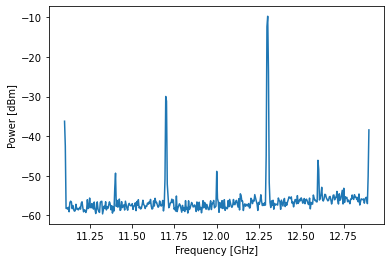

In [8]:
opt1 = IQOptimizer(mw_client, hd, sa, 12e9, 300e6, max_lower_sideband_pow = -50, param_guess = ([60, 0.7, 0.65, 0.005, 0.005]), phase_window = 20, q_window = 0.3, dc_i_window = 0.02, dc_q_window = 0.02)
#opt1.opt()

In [9]:
#opt1.sa.plot_trace()
opt1.opt_lower_sideband()
#opt1.opt()

KeyboardInterrupt: 

In [ ]:
# opt1.opt_lower_sideband()

In [ ]:
# opt1.initialize_reopt_params()
# opt1.opt()